# Hierarchical dynamic IDM (AR+IDM)

<img src="../Figs/Hierarchical_dynamic_IDM_PGM.png" width="600">

In [1]:
import arviz as az
import numpy as np
"""
# If pymc3
"""
# import pymc3 as pm
# from theano import tensor as tt
"""
# If pymc4
"""
import pymc as pm
import aesara.tensor as tt

import random
import pickle
import os
import sys
import matplotlib.pyplot as plt

sys.path.append('../')

from data.data_loader import read_training_data
from config import Config
from os import path
from pickle import UnpicklingError

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1116)

In [2]:
def load_training_data(base_path, step, min_traj_lenth, pair_id_list, N):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=min_traj_lenth)
    for pair_id in pair_id_list:
        if pair_id == pair_id_list[0]:
            xt = tracks[pair_id]['xFollReal']
            vt = tracks[pair_id]['vFollReal']
            s = tracks[pair_id]['sReal']
            dv = tracks[pair_id]['dvReal']
            label_v = tracks[pair_id]['vFollReal_next']
            label_x = tracks[pair_id]['xFollReal_next']
            id_idx = N*np.ones_like(label_v, dtype=int)
        else:
            xt = np.concatenate((xt,tracks[pair_id]['xFollReal']))
            vt = np.concatenate((vt,tracks[pair_id]['vFollReal']))
            s = np.concatenate((s,tracks[pair_id]['sReal']))
            dv = np.concatenate((dv, tracks[pair_id]['dvReal']))
            label_v = np.concatenate((label_v, tracks[pair_id]['vFollReal_next']))
            label_x = np.concatenate((label_x, tracks[pair_id]['xFollReal_next']))
            id_idx = np.concatenate((id_idx, N*np.ones_like(tracks[pair_id]['sReal'], dtype=int)))
        N +=1
    if step!=1:
        xt = xt[::step]
        vt = vt[::step]
        s = s[::step]
        dv = dv[::step]
        label_v = label_v[::step]
        label_x = label_x[::step]
        id_idx = id_idx[::step]
    
    print("Traj length:",min_traj_lenth*Config.dt, ", ID list:", pair_id_list, ", Data size:", label_v.shape)
    return xt, vt, s, dv, label_v, label_x, id_idx

def AR_IDM_hierarchical(base_path, step, d):
    xt, vt, s, dv, label_v, label_x, id_idx = load_training_data(base_path, step=step,
                                                    min_traj_lenth=50 * Config.frame_rate_orignial,
                                                    pair_id_list=Config.car_interactive_pair_list, N=0)

    xt2, vt2, s2, dv2, label_v2, label_x2, id_idx2 = load_training_data(base_path, step=step,
                                                         min_traj_lenth=50 * Config.frame_rate_orignial,
                                                         pair_id_list=Config.truck_interactive_pair_list,
                                                         N=len(Config.car_interactive_pair_list))
    xt = np.concatenate((xt, xt2))
    vt = np.concatenate((vt, vt2))
    s = np.concatenate((s, s2))
    dv = np.concatenate((dv, dv2))
    label_v = np.concatenate((label_v, label_v2))
    label_x = np.concatenate((label_x, label_x2))
    labels = np.vstack((label_v, label_x))
    print('labels:', labels.shape)
    id_idx = np.concatenate((id_idx, id_idx2))

    print("training size:", label_v.shape)
    print("s size", s.shape)
    ################################################

    dt = Config.dt

    D = 5

    N_veh = len(Config.car_interactive_pair_list) + len(Config.truck_interactive_pair_list)
    coords = {
        "veh_id": np.arange(N_veh),
    }

    with pm.Model(coords=coords) as hierarchical_model:
        
        def AR_IDM_xv(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv, xt, rho, d):
            sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
            a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)

            mean = vt + a * Config.dt

            for i in range(d):
                mean = tt.subtensor.set_subtensor(mean[d:-1], mean[d:-1] + rho[i] * (
                            vt[i + 1: -d + i] - vt[i: -d + i - 1] - a[i: -d + i - 1] * Config.dt))
            
            x_new = tt.stack([mean, xt + 0.5*(vt+mean)*Config.dt])
            return x_new

        id_idx = pm.ConstantData("id_idx", id_idx)
        s_ = pm.ConstantData("s", s)
        xt_ = pm.ConstantData("xt", xt)
        vt_ = pm.ConstantData("vt", vt)
        dv_ = pm.ConstantData("dv", dv)

        # Hyperpriors for group nodes
        chol, _, _ = pm.LKJCholeskyCov('chol', n=D, eta=2.0, sd_dist=pm.Exponential.dist(100, shape=D))
        cov = pm.Deterministic('cov', chol.dot(chol.T))
        
        vals_raw = pm.Normal('vals_raw',mu=0, sigma=1, shape=(N_veh, D), dims=('veh_id', ...))
        
        DELTA = 4
        
        log_mu = pm.Normal('log_mu', mu=0, sigma=1, shape=D)
        mu = pm.Deterministic('mu', tt.exp(log_mu))
        
        log_parameters = pm.Deterministic('log_mu_d', log_mu+tt.dot(chol,vals_raw.T).T)
        parameters = pm.Deterministic('mu_d', tt.exp(log_parameters))
        print("parameters.shape.eval():", parameters.shape.eval())

        s_a = pm.Exponential('s_a', lam=2e6)
        s_v = 1e-4
        s_x = 1e-2
        
        rho = pm.Normal('rho', mu=0., sigma=.2, size=d)

        for i in range(N_veh):
            id_idx_temp = (id_idx.eval() == i)
            name = 'llh' + str(i)

            covs = tt.stacklists([[(s_a ** 2 * Config.dt ** 2 + s_v ** 2), 0.5 * s_a ** 2 * Config.dt ** 3],
                                  [0.5 * s_a ** 2 * Config.dt ** 3, (s_a ** 2 * Config.dt ** 4) / 4 + s_x ** 2]])

            mu = AR_IDM_xv(33 * parameters[id_idx[id_idx_temp], 0],
                           2 * parameters[id_idx[id_idx_temp], 1],
                           1.6 * parameters[id_idx[id_idx_temp], 2],
                           1.5 * parameters[id_idx[id_idx_temp], 3],
                           1.67 * parameters[id_idx[id_idx_temp], 4],
                           DELTA,
                           s_[np.where(id_idx.eval() == i)[0]],
                           vt_[np.where(id_idx.eval() == i)[0]],
                           dv_[np.where(id_idx.eval() == i)[0]],
                           xt_[np.where(id_idx.eval() == i)[0]], rho, d)
            
            v_obs = pm.MvNormal(name,
                                mu=mu.T, cov=covs,
                                observed=labels[:, np.where(id_idx.eval() == i)[0]].T)

        tr = pm.sample(2500, tune=5000, random_seed=37, init='jitter+adapt_diag_grad', chains=1,
                       cores=14, discard_tuned_samples=True, return_inferencedata=True, target_accept=0.90)

    return tr, hierarchical_model

In [3]:
base_path = '../data/highD/'
step = 1
d = 6
tr, model = AR_IDM_hierarchical(base_path, step, d)

Traj length: 250.0 , ID list: [14, 35, 23, 25, 36, 38, 60, 90, 228, 232] , Data size: (3249,)
Traj length: 250.0 , ID list: [3, 4, 18, 52, 81, 144, 153, 162, 5, 241] , Data size: (3133,)
labels: (2, 6382)
training size: (6382,)
s size (6382,)
parameters.shape.eval(): [20  5]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Sequential sampling (1 chains in 1 job)
NUTS: [chol, vals_raw, log_mu, s_a, rho]


Sampling 1 chain for 5_000 tune and 2_500 draw iterations (5_000 + 2_500 draws total) took 42498 seconds.


In [4]:
# Save the trace in the `cache' folder
base_path = '../data/highD/'
cache = "../PGM_highD_joint/cache/AR{:d}_IDM_hierarchical.pkl".format(d)
if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tr = pickle.load(fp)
        fp.close()
        print("Load trace", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)
else:
    output_file = open(cache, 'wb')
    pickle.dump(tr, output_file)
    output_file.close()
    print("Generated and Saved", output_file, ": done!")

Generated and Saved <_io.BufferedWriter name='../PGM_highD_joint/cache/AR6_IDM_hierarchical.pkl'> : done!


In [35]:
print(tr.posterior.s_a.mean(axis=0).mean(axis=0))

<xarray.DataArray 's_a' ()>
array(0.01574407)


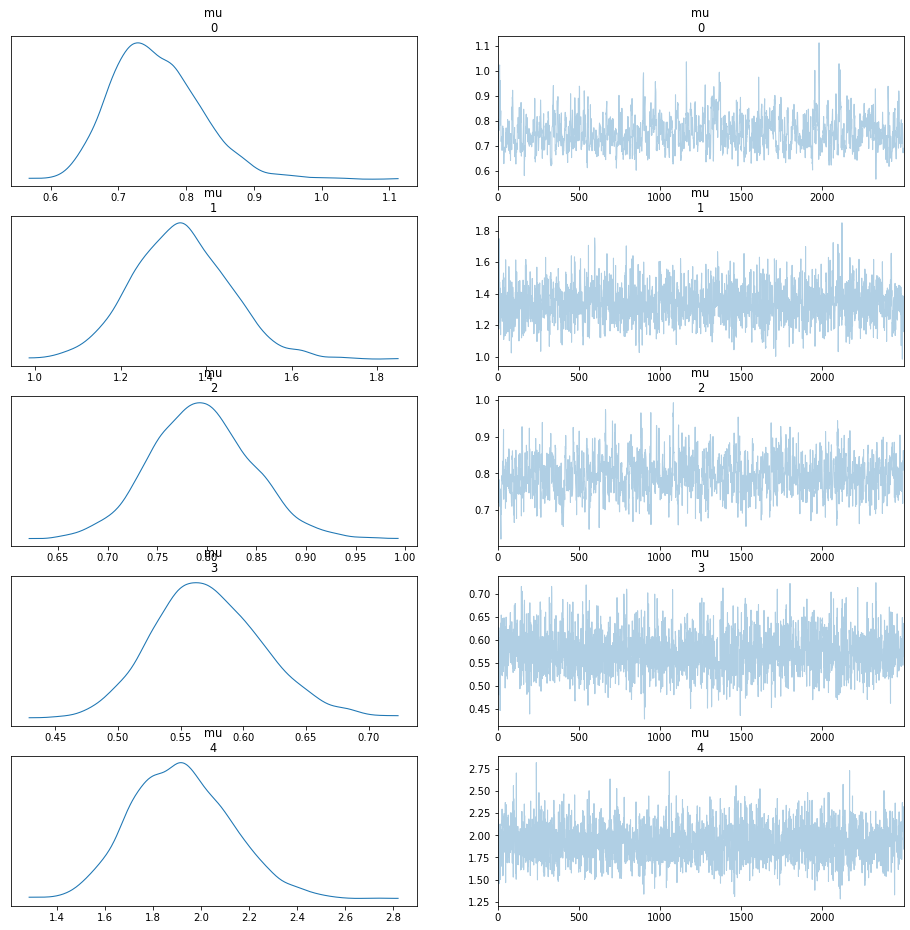

In [6]:
import arviz as az

_ = az.plot_trace(tr, var_names=["mu"], figsize=((16, 16)),compact=False)

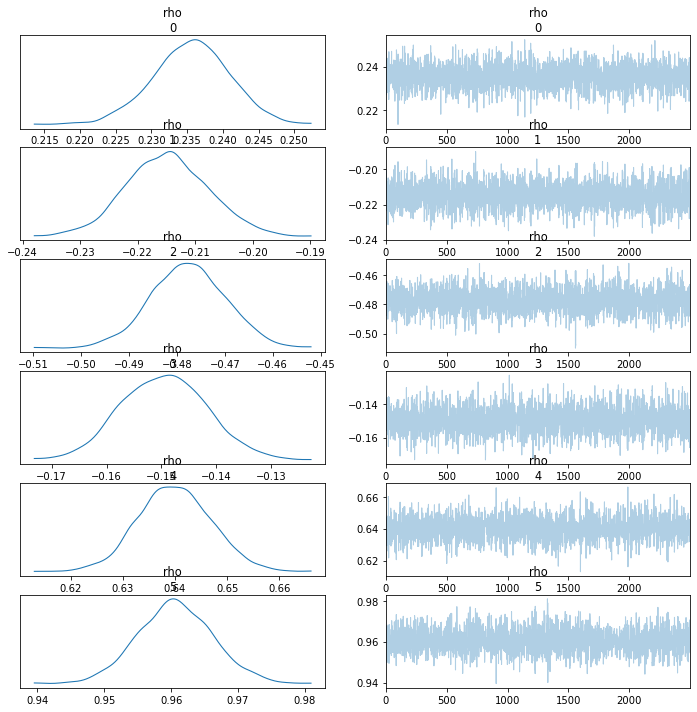

In [7]:
import arviz as az

_ = az.plot_trace(tr, var_names=["rho"],compact=False)

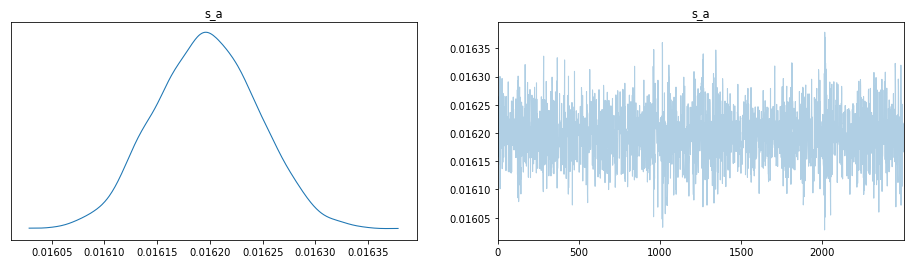

In [8]:
import arviz as az

_ = az.plot_trace(tr, var_names=["s_a"], figsize=((16, 4)))

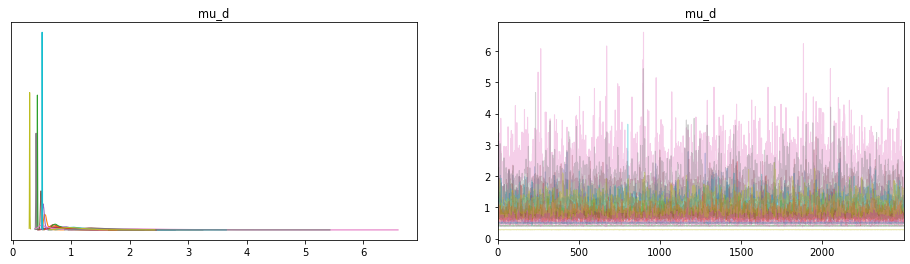

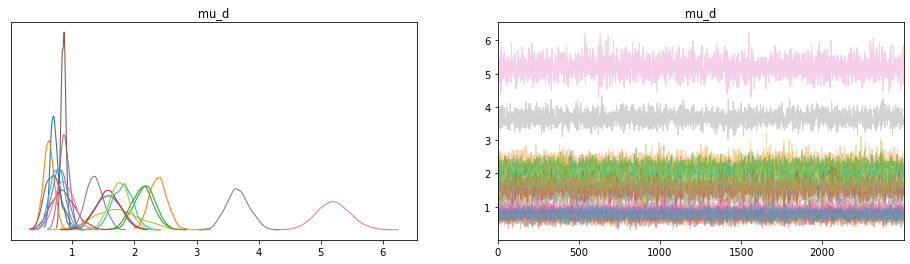

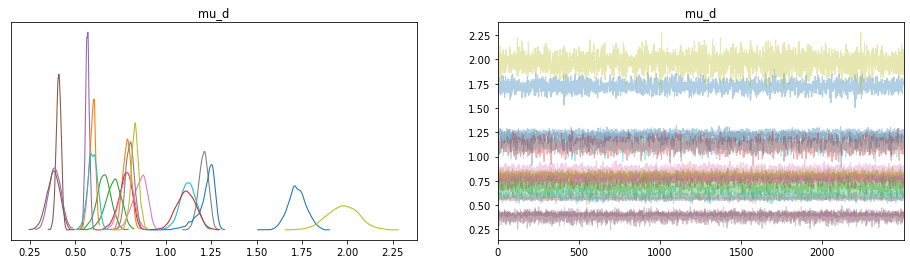

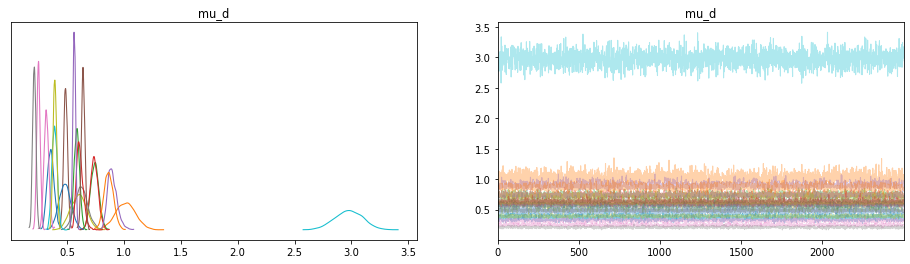

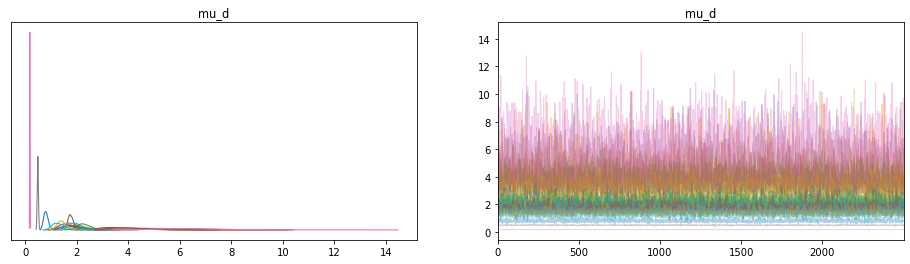

In [9]:
import arviz as az

_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":0}, figsize=((16, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":1}, figsize=((16, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":2}, figsize=((16, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":3}, figsize=((16, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":4}, figsize=((16, 4)),compact=True)

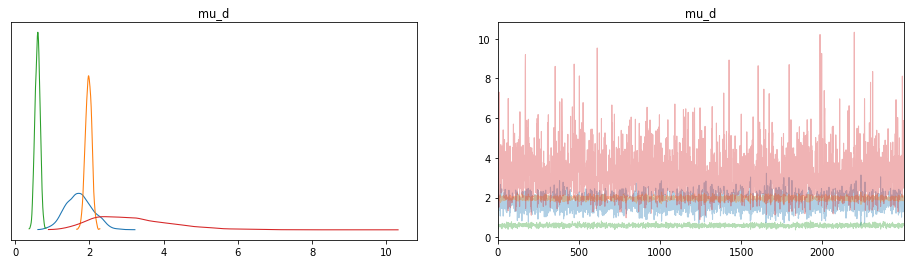

In [10]:
import arviz as az

driver_id = 8

_ = az.plot_trace(tr, var_names=["mu_d"],
                  coords={"mu_d_dim_0":driver_id, "mu_d_dim_1":[1,2,3,4]},
                  figsize=((16, 4)),compact=True)

In [11]:
az.summary(tr, var_names=["mu", "log_mu", 'rho'],coords={"chain":[0]}) # index 0-5 are: VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA

arviz - WARNING - Shape validation failed: input_shape: (1, 2500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.756,0.065,0.646,0.879,0.003,0.002,474.0,653.0,NaN
mu[1],1.341,0.113,1.118,1.539,0.003,0.002,1524.0,1893.0,NaN
mu[2],0.794,0.051,0.695,0.886,0.002,0.001,774.0,983.0,NaN
mu[3],0.572,0.045,0.494,0.660,0.001,0.001,1741.0,2062.0,NaN
mu[4],1.916,0.207,1.536,2.291,0.005,0.003,2050.0,2048.0,NaN
log_mu[0],-0.284,0.084,-0.436,-0.129,0.004,0.003,474.0,653.0,NaN
log_mu[1],0.290,0.084,0.129,0.445,0.002,0.002,1524.0,1893.0,NaN
log_mu[2],-0.232,0.064,-0.352,-0.110,0.002,0.002,774.0,983.0,NaN
log_mu[3],-0.561,0.078,-0.705,-0.414,0.002,0.001,1741.0,2062.0,NaN
log_mu[4],0.645,0.108,0.429,0.829,0.002,0.002,2050.0,2048.0,NaN


In [12]:
az.summary(tr, var_names=["mu_d"],coords={"chain":[0], "mu_d_dim_0": [0,10]}) # index 0-4 are: VMAX, DSAFE, TSAFE, AMAX, AMIN

arviz - WARNING - Shape validation failed: input_shape: (1, 2500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"mu_d[0, 0]",1.118,0.277,0.688,1.630,0.006,0.005,2014.0,1605.0,NaN
"mu_d[0, 1]",1.571,0.218,1.173,1.987,0.004,0.003,2949.0,1770.0,NaN
"mu_d[0, 2]",1.722,0.050,1.630,1.817,0.001,0.001,2765.0,1986.0,NaN
"mu_d[0, 3]",0.356,0.029,0.301,0.409,0.001,0.000,2836.0,2296.0,NaN
"mu_d[0, 4]",0.809,0.089,0.638,0.967,0.002,0.001,2541.0,2218.0,NaN
"mu_d[10, 0]",0.790,0.226,0.464,1.197,0.006,0.004,1500.0,1642.0,NaN
"mu_d[10, 1]",0.726,0.083,0.592,0.883,0.002,0.002,1451.0,1512.0,NaN
"mu_d[10, 2]",1.222,0.049,1.123,1.289,0.001,0.001,1533.0,1635.0,NaN
"mu_d[10, 3]",0.482,0.052,0.378,0.573,0.001,0.001,2533.0,1986.0,NaN
"mu_d[10, 4]",1.901,0.415,1.170,2.644,0.009,0.006,2499.0,1940.0,NaN


In [13]:
tr.posterior['mu_d'] = tr.posterior.mu_d[:,:,:,:] * [33, 2, 1.6, 1.5, 1.67]

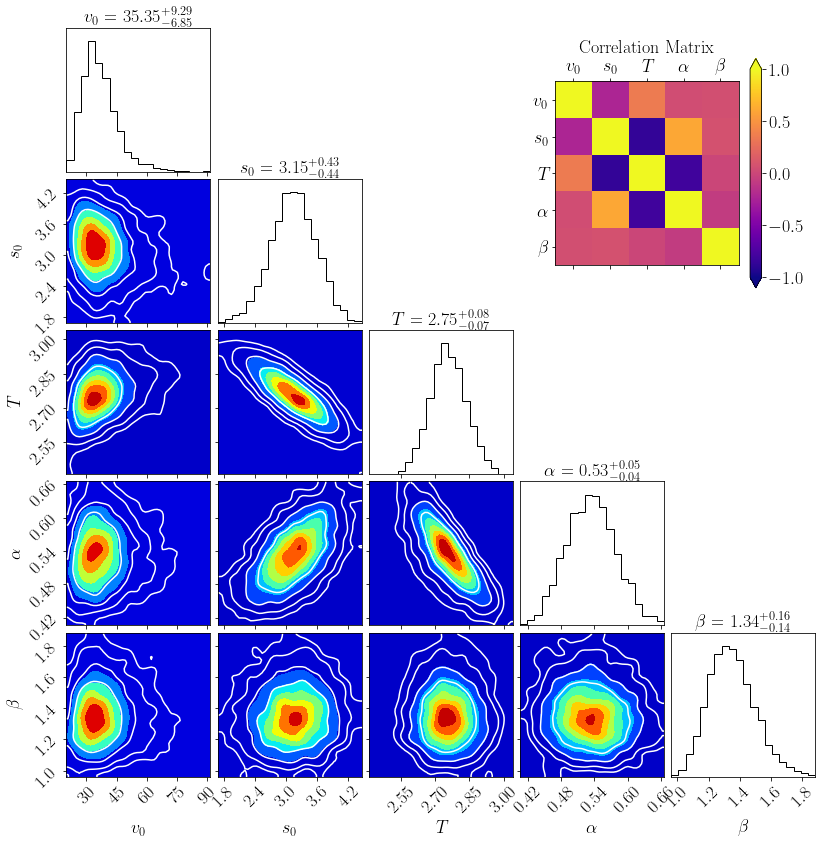

In [14]:
import corner

driver_id = 0

import matplotlib

label_list = [r'$v_0$',r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

figure_d = corner.corner(
    tr,
    var_names=["mu_d"], coords={"mu_d_dim_0":driver_id,"chain":[0]},
    smooth=1.8,
    color = 'k',
    plot_contours=True,
    plot_density=False,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure_d.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu_d[0,:,driver_id,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure_d.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

# figure_d.savefig('../Figs/B_IDM_hierarchical_driver2.pdf', dpi=300)

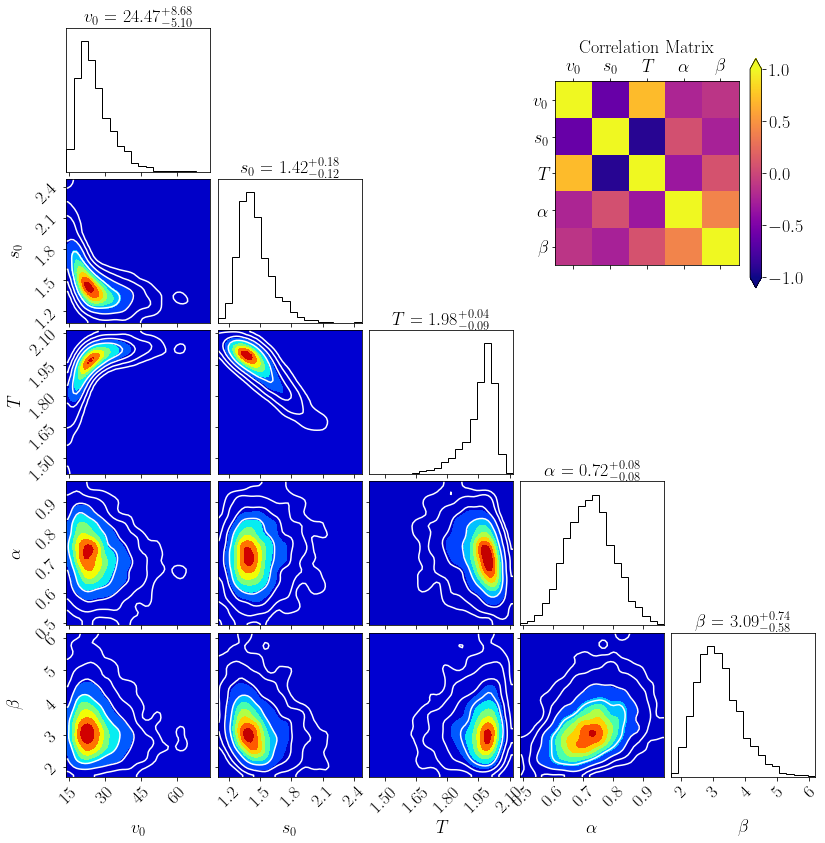

In [15]:
import corner

driver_id = 10

import matplotlib

label_list = [r'$v_0$',r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

figure_d = corner.corner(
    tr,
    var_names=["mu_d"], coords={"mu_d_dim_0":driver_id,"chain":[0]},
    smooth=1.8,
    color = 'k',
    plot_contours=True,
    plot_density=False,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure_d.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu_d[0,:,driver_id,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure_d.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

# figure_d.savefig('../Figs/B_IDM_hierarchical_driver8.pdf', dpi=300)

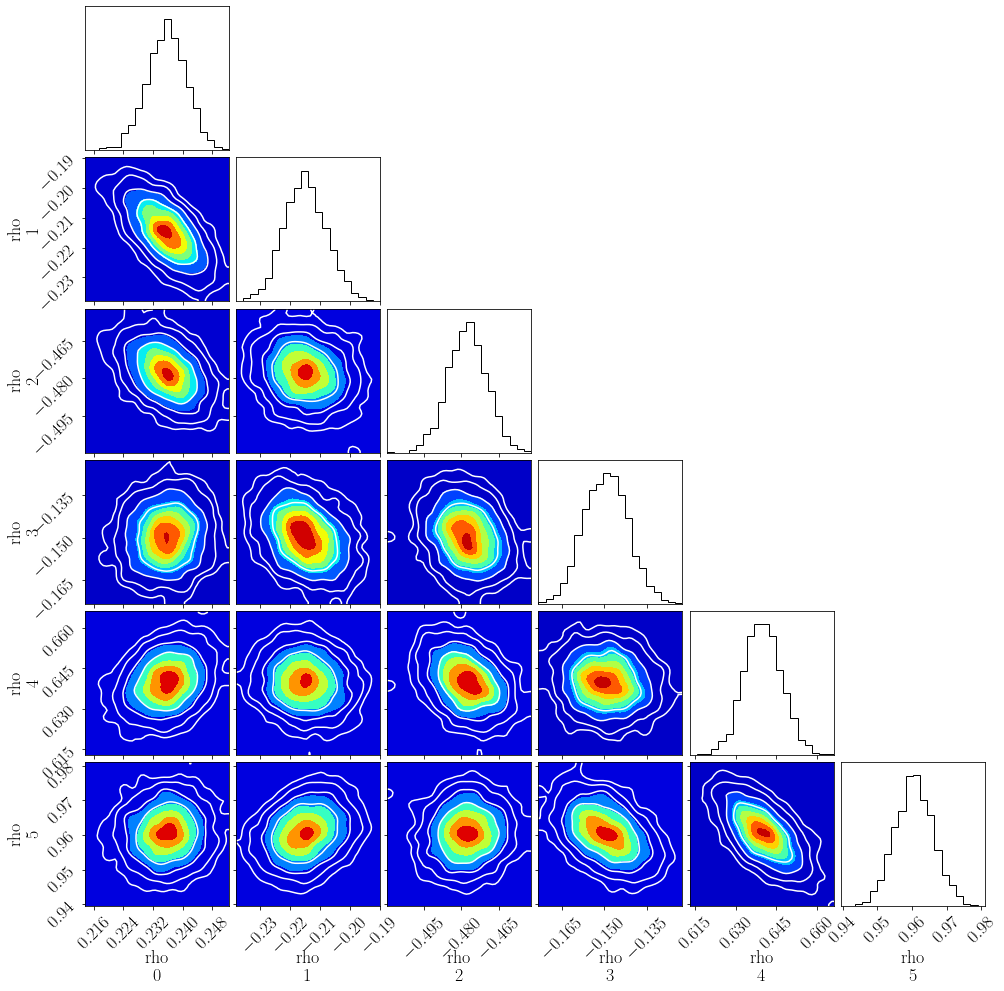

In [16]:
figure_d = corner.corner(
    tr,
    var_names=["rho"],
    smooth=1.8,
    color = 'k',
    plot_contours=True,
    plot_density=False,
    plot_datapoints = False,
    bins = 20,
    show_titles=False,
    reverse=False,
)